<a href="https://colab.research.google.com/github/siming415/uiuc-cs598-dlh-project/blob/main/project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...
Dataset columns: ['age', 'death', 'sex', 'hospdead', 'slos', 'd.time', 'dzgroup', 'dzclass', 'num.co', 'edu', 'income', 'scoma', 'charges', 'totcst', 'totmcst', 'avtisst', 'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday', 'diabetes', 'dementia', 'ca', 'prg2m', 'prg6m', 'dnr', 'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls', 'sfdm2', 'adlsc']
Available columns selected: ['age', 'sex', 'dzgroup', 'num.co', 'edu', 'income', 'scoma', 'avtisst', 'sps', 'dnr', 'ca', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls', 'd.time', 'death']
Handling missing values using imputation...
Imputed column 'edu' with median: 12.0
Imputed column 'scoma' with median: 0.0
Imputed column 'avtisst' with median: 19.5
Imputed column 'sps' with median: 23.8984375
Imputed column 'meanbp' with median: 77.0
Imputed column 'wblc' with med

<ipython-input-56-4eb545c2b556>:437: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col].fillna(median_val, inplace=True)
<ipython-input-56-4eb545c2b556>:444: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

            --- Returned from pz_given_x ---
            --- Calling _initialize_centroids ---
            --- _initialize_centroids Start ---
            --- _initialize_centroids End ---
            --- Returned from _initialize_centroids ---
            --- Calling _cluster_data ---
            --- _cluster_data Start ---
                --- Calling cluster_assignment ---
                --- Returned from cluster_assignment ---
                --- Calling update_pop_pi ---
                --- Returned from update_pop_pi ---
                --- Defining update_pop_pi_op ---
                --- Defined update_pop_pi_op ---
                --- Defining clustering_loss ---
                --- Defined clustering_loss ---
            --- _cluster_data End ---
            --- Returned from _cluster_data ---
            --- Calling _risk_model (decoder) ---
            --- _risk_model Start ---
                --- Calling pt_given_z ---
                --- Returned from pt_given_z ---
     

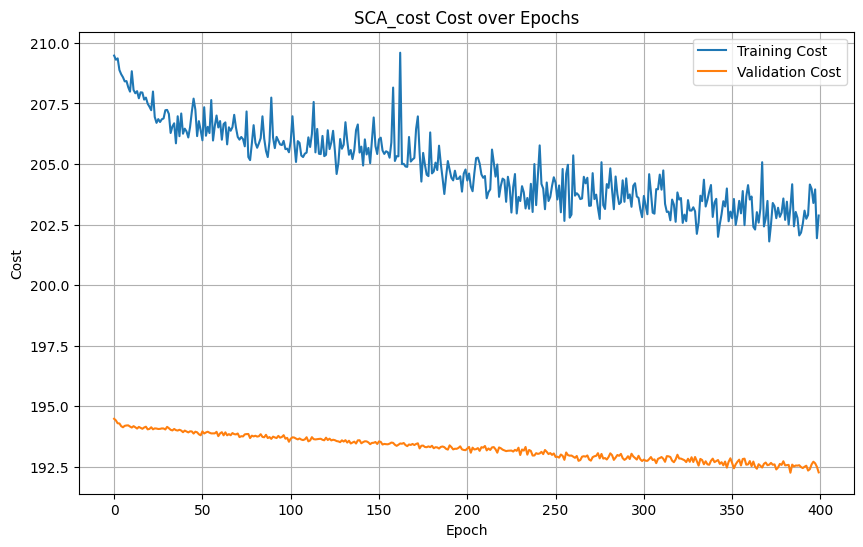

In [ ]:
# Install required packages with more compatible versions
# !pip install pandas lifelines matplotlib seaborn scikit-learn tensorflow

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from scipy.stats import spearmanr  # Updated import
import logging
import threading
import time
from datetime import timedelta
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter

# Enable TensorFlow 1.x compatibility mode
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

# Set random seeds for reproducibility
SEED = 31415
np.random.seed(SEED)
# Set the global TF seed *once* here, not inside the graph or class init
tf.compat.v1.set_random_seed(SEED)


# Configure logging (configure once globally)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Model hyperparameters
params = {
    'num_iterations': 40000, # Might be unused if max_epochs is primary
    'batch_size': 500,
    'seed': SEED, # Use the global SEED
    'require_improvement': 10000,
    'learning_rate': 1e-4,  # << REDUCED LEARNING RATE
    'beta1': 0.9,
    'beta2': 0.999,
    'hidden_dim': [50, 50, 50],
    'l2_reg': 0.001,
    'l1_reg': 0.001, # Note: l1_loss function not used in SCA objective
    'keep_prob': 0.8,
    'sample_size': 200 # Seems unused in the provided SCA class logic
}


# Command line arguments
class Args:
    def __init__(self):
        self.dataset = 'support'  # dataset in [support, flchain, seer, sleep]
        self.GPUID = '0'  # GPU ID - Note: TF might handle GPU assignment differently now
        self.n_clusters = 25  # K upper bound of number of clusters
        self.gamma_0 = 2  # concentration parameter in Dirichlet Process

        # Add params to args
        for key, value in params.items():
            setattr(self, key, value)

args = Args()


# TensorFlow helper functions
def create_centroids(n_clusters, dim, seed=31415):
    """Create initial centroids for clustering"""
    # Use reuse=tf.compat.v1.AUTO_REUSE for safety if called multiple times
    with tf.compat.v1.variable_scope("centroids", reuse=tf.compat.v1.AUTO_REUSE):
        centroids = tf.compat.v1.get_variable(
            name="centroids",
            shape=[n_clusters, dim],
            initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=seed),
            dtype=tf.float32
        )
    return centroids

def create_pop_pi(n_clusters, seed=31415): # Seed might not be needed for constant_initializer
    """Create initial population proportions for clustering"""
    with tf.compat.v1.variable_scope("pop_pi", reuse=tf.compat.v1.AUTO_REUSE):
        pop_pi = tf.compat.v1.get_variable(
            name="pop_pi",
            shape=[n_clusters],
            initializer=tf.compat.v1.constant_initializer(1.0 / n_clusters),
            dtype=tf.float32
        )
    return pop_pi

def show_all_variables():
    """Show all variables in the TensorFlow graph"""
    # Ensure this is called within a graph context if needed
    # with graph.as_default(): ...
    print("--- Trainable Variables ---")
    total_count = 0
    for idx, op in enumerate(tf.compat.v1.trainable_variables()):
        shape = op.get_shape()
        # Use as_list() carefully, might fail on unknown shapes, though less likely for variables
        try:
            shape_list = shape.as_list()
            count = np.prod(shape_list) if None not in shape_list else 'Unknown'
        except ValueError:
            shape_list = 'Unknown'
            count = 'Unknown'

        print("[%2d] %s %s = %s" % (idx, op.name, shape_list, count))
        if isinstance(count, (int, float)) and not np.isnan(count):
             total_count += int(count)
    print("[Total] variable size: %s" % "{:,}".format(total_count))
    print("-------------------------")


# Metrics and loss functions
def l2_loss(scale=0.001):
    """L2 regularization loss"""
    # Ensure this operates on the correct graph's variables
    trainable_vars = tf.compat.v1.trainable_variables()
    if not trainable_vars:
        print("WARN: No trainable variables found for L2 loss.")
        return tf.constant(0.0, dtype=tf.float32)

    l2_losses = [tf.nn.l2_loss(v) for v in trainable_vars if 'bias' not in v.name]
    if not l2_losses:
        print("WARN: No variables applicable for L2 loss (excluding biases).")
        return tf.constant(0.0, dtype=tf.float32)

    l2 = tf.add_n(l2_losses)
    return scale * l2

# l1_loss is defined but not used in the SCA objective function provided
def l1_loss(scale=0.001):
    """L1 regularization loss"""
    trainable_vars = tf.compat.v1.trainable_variables()
    if not trainable_vars: return tf.constant(0.0, dtype=tf.float32)
    l1_losses = [tf.reduce_sum(tf.abs(v)) for v in trainable_vars if 'bias' not in v.name]
    if not l1_losses: return tf.constant(0.0, dtype=tf.float32)
    l1 = tf.add_n(l1_losses)
    return scale * l1

def accuracy_loss(predicted_time, t, e):
    """Calculate accuracy loss for survival prediction.
       Assumes inputs are shaped [batch_size, 1]"""

    # Ensure boolean masks work correctly
    e_bool = tf.cast(e, tf.bool)
    e_bool_flat = tf.reshape(e_bool, [-1]) # Flatten mask

    # For uncensored instances (e=1)
    uncensored_idx = e_bool_flat
    uncensored_t = tf.boolean_mask(t, uncensored_idx)
    uncensored_predicted = tf.boolean_mask(predicted_time, uncensored_idx)
    # Add epsilon to prevent log(0) or division by zero if using relative error later
    # loss_uncensored = tf.reduce_mean(tf.abs(uncensored_predicted - uncensored_t))
    # Use Huber loss for potentially more robustness to outliers?
    delta = 1.0 # Huber delta
    abs_error_uncensored = tf.abs(uncensored_predicted - uncensored_t)
    quadratic_uncensored = tf.minimum(abs_error_uncensored, delta)
    linear_uncensored = abs_error_uncensored - quadratic_uncensored
    loss_uncensored = tf.reduce_mean(0.5 * quadratic_uncensored**2 + delta * linear_uncensored)


    # For censored instances (e=0)
    censored_idx = tf.logical_not(e_bool_flat)
    censored_t = tf.boolean_mask(t, censored_idx)
    censored_predicted = tf.boolean_mask(predicted_time, censored_idx)
    # Calculate violation for censored data
    censored_violation = tf.maximum(0.0, censored_predicted - censored_t) # Penalize if predicted_time < censored_time
    # loss_censored = tf.reduce_mean(tf.maximum(0.0, censored_t - censored_predicted)) # Original logic? seems inverted
    loss_censored = tf.reduce_mean(censored_violation) # Use the violation term

    # Combine losses (handle cases where one set might be empty)
    loss = tf.cond(tf.logical_and(tf.size(loss_uncensored) > 0, tf.size(loss_censored) > 0),
                   lambda: loss_uncensored + loss_censored,
                   lambda: tf.cond(tf.size(loss_uncensored) > 0,
                                   lambda: loss_uncensored,
                                   lambda: tf.cond(tf.size(loss_censored) > 0,
                                                   lambda: loss_censored,
                                                   lambda: tf.constant(0.0, dtype=tf.float32))))

    return loss


def plot_cost(train_cost, valid_cost, name):
    """Plot training and validation cost"""
    if not train_cost or not valid_cost:
        print("WARN: Empty cost lists, skipping plot.")
        return
    plt.figure(figsize=(10, 6))
    plt.plot(train_cost, label='Training Cost')
    plt.plot(valid_cost, label='Validation Cost')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title(f'{name} Cost over Epochs')
    plt.legend()
    plt.grid(True)
    # Add y-axis limits if cost is too variable?
    # plt.ylim(bottom=0, top=max(max(train_cost), max(valid_cost))*1.1) # Example limit
    plt.savefig(f'{name}_cost.png')
    print(f"Cost plot saved to {name}_cost.png")
    # plt.show() # Avoid blocking in non-interactive environments


# Clustering functions
def cluster_assignment(z, centroids, pop_pi):
    """Assign data points to clusters based on distance to centroids"""
    # Add epsilon to pop_pi for log stability
    log_pop_pi = tf.math.log(tf.maximum(pop_pi, 1e-10))

    # Compute distances to centroids
    z_expand = tf.expand_dims(z, axis=1)  # [batch_size, 1, latent_dim]
    centroids_expand = tf.expand_dims(centroids, axis=0)  # [1, n_clusters, latent_dim]
    # Use safe subtraction
    diff = z_expand - centroids_expand
    distances_sq = tf.reduce_sum(tf.square(diff), axis=2)  # [batch_size, n_clusters]

    # Compute assignment probabilities (logits)
    # Check for NaNs/Infs in distances or log_pop_pi
    distances_sq = tf.debugging.check_numerics(distances_sq, "Distances")
    log_pop_pi = tf.debugging.check_numerics(log_pop_pi, "Log Pop Pi")

    logits = -distances_sq + log_pop_pi
    logits = tf.debugging.check_numerics(logits, "Logits")

    cluster_prob = tf.nn.softmax(logits, axis=1) # Ensure softmax is applied correctly
    cluster_prob = tf.debugging.check_numerics(cluster_prob, "Cluster Prob")

    # Get cluster indices
    cluster_idx = tf.argmax(cluster_prob, axis=1)

    return cluster_prob, cluster_idx

def update_pop_pi(cluster_prob, gamma_0, n_clusters):
    """Update population proportions based on assignments"""
    # Sum responsibilities across batch
    # Add epsilon to cluster_prob sum? Should be okay if cluster_prob is valid probability dist.
    N_k = tf.reduce_sum(cluster_prob, axis=0)  # [n_clusters]
    N_k = tf.debugging.check_numerics(N_k, "N_k in update_pop_pi")

    # Add Dirichlet prior
    gamma_term = gamma_0 / tf.cast(n_clusters, tf.float32) # Ensure float division
    N_k_plus_gamma = N_k + gamma_term

    # Normalize to get updated proportions
    sum_N_k_plus_gamma = tf.reduce_sum(N_k_plus_gamma)
    # Avoid division by zero
    updated_pop_pi = N_k_plus_gamma / tf.maximum(sum_N_k_plus_gamma, 1e-10)
    updated_pop_pi = tf.debugging.check_numerics(updated_pop_pi, "Updated Pop Pi")

    return updated_pop_pi

# run_k_means seems unused in the main SCA logic
def run_k_means(data, n_clusters, max_iter=100):
    """Run K-means clustering algorithm"""
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=max_iter, random_state=31415) # Set n_init
    labels = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    return centroids, labels


# Example using RandomNormal with stddev=0.01
def pz_given_x(x, hidden_dim, keep_prob, is_training, batch_norm=True, seed=31415):
    """
    Encoder network using tf.keras.layers and tf.cond for BN and Dropout.
    Uses RandomNormal initializer.
    """
    # Use a different initializer
    initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed=seed)
    # Or try VarianceScaling:
    # initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='normal', seed=seed)

    with tf.compat.v1.variable_scope("encoder", reuse=tf.compat.v1.AUTO_REUSE):
        h = x
        h = tf.debugging.check_numerics(h, "Input to pz_given_x")
        for i, hidden_size in enumerate(hidden_dim):
            layer_name_prefix = f"layer_{i}"
            dense_layer = tf.keras.layers.Dense(
                hidden_size,
                activation=None,
                kernel_initializer=initializer, # USE NEW INITIALIZER
                name=f"{layer_name_prefix}_dense"
            )
            # ... (rest of the layer definitions and logic remain the same) ...
            if batch_norm:
                 bn_layer = tf.keras.layers.BatchNormalization(name=f"{layer_name_prefix}_bn")
            activation_layer = tf.keras.layers.Activation('relu', name=f"{layer_name_prefix}_relu")
            dropout_layer = tf.keras.layers.Dropout(rate=1.0 - keep_prob, name=f"{layer_name_prefix}_dropout")

            h = dense_layer(h)
            h = tf.debugging.check_numerics(h, f"After dense {i}")
            if batch_norm:
                h_bn_true = lambda: bn_layer(h, training=True)
                h_bn_false = lambda: bn_layer(h, training=False)
                h = tf.cond(is_training, h_bn_true, h_bn_false, name=f"{layer_name_prefix}_bn_cond")
                h = tf.debugging.check_numerics(h, f"After BN {i}")
            h = activation_layer(h)
            h = tf.debugging.check_numerics(h, f"After activation {i}")
            h_dropout_true = lambda: dropout_layer(h, training=True)
            h_dropout_false = lambda: h
            h = tf.cond(is_training, h_dropout_true, h_dropout_false, name=f"{layer_name_prefix}_dropout_cond")
            h = tf.debugging.check_numerics(h, f"After dropout {i}")

        # Final layer for latent representation
        z_dense_layer = tf.keras.layers.Dense(
            hidden_dim[-1],
            activation=None,
            kernel_initializer=initializer, # USE NEW INITIALIZER
            name="z"
        )
        z = z_dense_layer(h)
        z = tf.debugging.check_numerics(z, "Final z in pz_given_x")
    return z

def pt_given_z(z, hidden_dim, keep_prob, is_training, batch_norm=True, seed=31415):
    """
    Decoder network using tf.keras.layers and tf.cond for BN and Dropout.
    Uses RandomNormal initializer.
    """
    # Use a different initializer
    initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed=seed)
    # Or try VarianceScaling:
    # initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='normal', seed=seed)

    with tf.compat.v1.variable_scope("decoder", reuse=tf.compat.v1.AUTO_REUSE):
        h = z
        h = tf.debugging.check_numerics(h, "Input z to pt_given_z")
        for i, hidden_size in enumerate(hidden_dim):
            layer_name_prefix = f"layer_{i}"
            dense_layer = tf.keras.layers.Dense(
                hidden_size,
                activation=None,
                kernel_initializer=initializer, # USE NEW INITIALIZER
                 name=f"{layer_name_prefix}_dense"
            )
             # ... (rest of the layer definitions and logic remain the same) ...
            if batch_norm:
                 bn_layer = tf.keras.layers.BatchNormalization(name=f"{layer_name_prefix}_bn")
            activation_layer = tf.keras.layers.Activation('relu', name=f"{layer_name_prefix}_relu")
            dropout_layer = tf.keras.layers.Dropout(rate=1.0 - keep_prob, name=f"{layer_name_prefix}_dropout")

            h = dense_layer(h)
            h = tf.debugging.check_numerics(h, f"After dense {i} in decoder")
            if batch_norm:
                h_bn_true = lambda: bn_layer(h, training=True)
                h_bn_false = lambda: bn_layer(h, training=False)
                h = tf.cond(is_training, h_bn_true, h_bn_false, name=f"{layer_name_prefix}_bn_cond")
                h = tf.debugging.check_numerics(h, f"After BN {i} in decoder")
            h = activation_layer(h)
            h = tf.debugging.check_numerics(h, f"After activation {i} in decoder")
            h_dropout_true = lambda: dropout_layer(h, training=True)
            h_dropout_false = lambda: h
            h = tf.cond(is_training, h_dropout_true, h_dropout_false, name=f"{layer_name_prefix}_dropout_cond")
            h = tf.debugging.check_numerics(h, f"After dropout {i} in decoder")

        # Output layers for Weibull parameters
        alpha_dense_layer = tf.keras.layers.Dense(
            1,
            activation='softplus',
            kernel_initializer=initializer, # USE NEW INITIALIZER
            name="alpha"
        )
        beta_dense_layer = tf.keras.layers.Dense(
            1,
            activation='softplus',
            kernel_initializer=initializer, # USE NEW INITIALIZER
            name="beta"
        )
        alpha = alpha_dense_layer(h)
        beta = beta_dense_layer(h)
        alpha = tf.debugging.check_numerics(alpha, "Alpha output")
        beta = tf.debugging.check_numerics(beta, "Beta output")
    return alpha, beta


# Calibration function (unused in main SCA logic, but available)
def km_estimator(event_times, event_indicators, time_points=None):
    """
    Kaplan-Meier estimator for survival function.
    """
    kmf = KaplanMeierFitter()
    kmf.fit(event_times, event_observed=event_indicators)

    if time_points is None:
        # Use default time points from the KM fit
        time_points = kmf.timeline

    # Handle cases where time_points might be outside the fitted range
    survival_probs = kmf.survival_function_at_times(time_points).values

    return time_points, survival_probs

# Support dataset loading function - USING IMPUTATION
def generate_support_data():
    """Generate data from SUPPORT dataset using imputation."""
    data_dir = 'data/support'
    csv_path = os.path.join(data_dir, 'support2.csv')

    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)

    if not os.path.exists(csv_path):
        print("Downloading SUPPORT dataset...")
        try:
            import requests
            url = 'https://raw.githubusercontent.com/paidamoyo/survival_cluster_analysis/master/data/support/support2.csv'
            response = requests.get(url)
            response.raise_for_status()
            with open(csv_path, 'wb') as f: f.write(response.content)
            print("Download complete.")
        except Exception as e: print(f"Error downloading SUPPORT dataset: {e}"); raise

    try: df = pd.read_csv(csv_path)
    except Exception as e: print(f"Error reading CSV file {csv_path}: {e}"); raise

    print("Dataset columns:", df.columns.tolist())

    desired_cols = ['age', 'sex', 'dzgroup', 'num.co', 'edu', 'income', 'scoma', 'avtisst', 'sps', 'dnr',
            'ca', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose',
            'bun', 'urine', 'adlp', 'adls', 'd.time', 'death']
    available_cols = [col for col in desired_cols if col in df.columns]
    print("Available columns selected:", available_cols)
    df_filtered = df[available_cols].copy()

    # --- IMPUTATION ---
    print("Handling missing values using imputation...")
    # Separate categorical and numerical columns *before* imputation
    cat_cols_for_impute = ['sex', 'dzgroup', 'income', 'ca', 'dnr']
    potential_cat_cols = [col for col in cat_cols_for_impute if col in df_filtered.columns]
    numerical_cols = [col for col in df_filtered.columns if col not in potential_cat_cols and col not in ['d.time', 'death']]
    target_cols = ['d.time', 'death'] # Keep separate for now

    # Impute numerical with median
    for col in numerical_cols:
        if df_filtered[col].isnull().any():
            median_val = df_filtered[col].median()
            df_filtered[col].fillna(median_val, inplace=True)
            print(f"Imputed column '{col}' with median: {median_val}")

    # Impute categorical with mode (get the first mode if multiple)
    for col in potential_cat_cols:
         if df_filtered[col].isnull().any():
            mode_val = df_filtered[col].mode()[0]
            df_filtered[col].fillna(mode_val, inplace=True)
            print(f"Imputed column '{col}' with mode: {mode_val}")

    # Drop rows ONLY if 'd.time' or 'death' are missing (essential targets)
    initial_rows = df_filtered.shape[0]
    df_filtered.dropna(subset=target_cols, inplace=True)
    print(f"Dropped {initial_rows - df_filtered.shape[0]} rows with missing 'd.time' or 'death'.")
    print(f"Shape after imputation and target dropna: {df_filtered.shape}")
    # --- END IMPUTATION ---


    # Convert categorical variables to one-hot encoding
    df_encoded = pd.get_dummies(df_filtered, columns=potential_cat_cols, drop_first=True, dtype=float)

    # Select features and target variables
    feature_cols = [col for col in df_encoded.columns if col not in target_cols]
    X = df_encoded[feature_cols].values
    T = df_encoded['d.time'].values
    E = df_encoded['death'].values

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into train, validation, and test sets (use stratification)
    try:
        X_train_val, X_test, T_train_val, T_test, E_train_val, E_test = train_test_split(
            X, T, E, test_size=0.2, random_state=SEED, stratify=E)
        X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(
            X_train_val, T_train_val, E_train_val, test_size=0.2, random_state=SEED, stratify=E_train_val)
    except ValueError as e:
        print(f"Warning: Stratification failed during split (likely small groups). Retrying without stratification. Error: {e}")
        X_train_val, X_test, T_train_val, T_test, E_train_val, E_test = train_test_split(
            X, T, E, test_size=0.2, random_state=SEED)
        X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(
            X_train_val, T_train_val, E_train_val, test_size=0.2, random_state=SEED)


    # Create data dictionaries
    train_data = {'x': X_train.astype(np.float32), 't': T_train.astype(np.float32), 'e': E_train.astype(np.float32)}
    valid_data = {'x': X_val.astype(np.float32), 't': T_val.astype(np.float32), 'e': E_val.astype(np.float32)}
    test_data = {'x': X_test.astype(np.float32), 't': T_test.astype(np.float32), 'e': E_test.astype(np.float32)}

    data_set = {'train': train_data, 'valid': valid_data, 'test': test_data}

    print(f"Support dataset loaded: {X_train.shape[0]} train, {X_val.shape[0]} validation, {X_test.shape[0]} test samples")
    print(f"Number of features: {X_train.shape[1]}") # Feature count might change slightly

    return data_set

# Flchain dataset loading function (similar structure, add checks if used)
def generate_flchain_data():
    """Generate data from Flchain dataset"""
    data_dir = 'data/flchain'
    csv_path = os.path.join(data_dir, 'flchain.csv')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)
    if not os.path.exists(csv_path):
        print("Downloading Flchain dataset...")
        try:
            import requests
            url = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/survival/flchain.csv'
            response = requests.get(url)
            response.raise_for_status()
            with open(csv_path, 'wb') as f: f.write(response.content)
            print("Download complete.")
        except Exception as e: print(f"Error downloading Flchain dataset: {e}"); raise

    try: df = pd.read_csv(csv_path)
    except Exception as e: print(f"Error reading CSV file {csv_path}: {e}"); raise

    # Data preprocessing
    cols = ['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus', 'futime', 'death']
    df_filtered = df[cols].copy()
    df_filtered.dropna(inplace=True) # Simple dropna for now
    if df_filtered.empty: raise ValueError("Flchain DataFrame empty after dropna.")

    cat_cols = ['sex', 'flc.grp', 'mgus']
    df_encoded = pd.get_dummies(df_filtered, columns=cat_cols, drop_first=True, dtype=float)

    feature_cols = [col for col in df_encoded.columns if col not in ['futime', 'death']]
    X = df_encoded[feature_cols].values
    T = df_encoded['futime'].values
    E = df_encoded['death'].values

    # Add checks for NaNs/Infs here if needed

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data
    try:
        X_train_val, X_test, T_train_val, T_test, E_train_val, E_test = train_test_split(
            X, T, E, test_size=0.2, random_state=SEED, stratify=E)
        X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(
            X_train_val, T_train_val, E_train_val, test_size=0.2, random_state=SEED, stratify=E_train_val)
    except ValueError as e:
       print(f"Error during train/test split (flchain): {e}")
       X_train_val, X_test, T_train_val, T_test, E_train_val, E_test = train_test_split(
          X, T, E, test_size=0.2, random_state=SEED)
       X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(
          X_train_val, T_train_val, E_train_val, test_size=0.2, random_state=SEED)

    train_data = {'x': X_train.astype(np.float32), 't': T_train.astype(np.float32), 'e': E_train.astype(np.float32)}
    valid_data = {'x': X_val.astype(np.float32), 't': T_val.astype(np.float32), 'e': E_val.astype(np.float32)}
    test_data = {'x': X_test.astype(np.float32), 't': T_test.astype(np.float32), 'e': E_test.astype(np.float32)}

    data_set = {'train': train_data, 'valid': valid_data, 'test': test_data}

    print(f"Flchain dataset loaded: {X_train.shape[0]} train, {X_val.shape[0]} validation, {X_test.shape[0]} test samples")
    print(f"Number of features: {X_train.shape[1]}")

    return data_set


# --- Survival Cluster Analysis (SCA) Class ---
class SCA(object):
    def __init__(self,
                 batch_size,
                 learning_rate,
                 beta1,
                 beta2,
                 require_improvement,
                 seed,
                 num_iterations, # Unused if max_epochs is primary
                 hidden_dim,
                 input_dim,
                 num_examples,
                 keep_prob,
                 train_data,
                 valid_data,
                 test_data,
                 sample_size, # Unused in current logic
                 l2_reg,
                 max_epochs,
                 gamma_0,
                 n_clusters):

        print("--- SCA Init Start ---")
        self.max_epochs = max_epochs
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.seed = seed
        self.require_improvement = require_improvement
        # self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_reg = l2_reg
        # self.sample_size = sample_size
        self.batch_norm = True  # <<< ADD THIS LINE BACK

        # Config Proto for TF session
        self.config = tf.compat.v1.ConfigProto(log_device_placement=False, allow_soft_placement=True)
        self.config.gpu_options.allow_growth = True

        # Load Data References (ensure they are float32)
        self.train_x = train_data['x']
        self.train_t = train_data['t']
        self.train_e = train_data['e']
        # ... rest of data loading ...
        self.valid_x = valid_data['x']
        self.valid_t = valid_data['t']
        self.valid_e = valid_data['e']
        self.test_x = test_data['x']
        self.test_t = test_data['t']
        self.test_e = test_data['e']

        self.keep_prob = keep_prob
        self.input_dim = input_dim
        self.num_examples = num_examples
        self.n_clusters = n_clusters
        self.gamma_0 = gamma_0

        self.model_name = 'SCA'

        print("--- Calling _build_graph ---")
        self._build_graph()
        print("--- Returned from _build_graph ---")

        # Initialize metric lists
        self.train_cost, self.train_ci, self.train_accuracy, self.train_clustering = [], [], [], []
        self.valid_cost, self.valid_ci, self.valid_accuracy, self.valid_clustering = [], [], [], []
        print("--- SCA Init End ---")
    # ... rest of the SCA class methods ...

    def _build_graph(self):
        print("    --- _build_graph Start ---")
        self.G = tf.Graph()
        with self.G.as_default():
            # Set graph-level seed *inside* the graph context
            tf.compat.v1.set_random_seed(self.seed)
            print("        --- Graph Seed Set ---")

            print("        --- Defining Placeholders ---")
            self.x = tf.compat.v1.placeholder(tf.float32, shape=[None, self.input_dim], name='x')
            self.e = tf.compat.v1.placeholder(tf.float32, shape=[None], name='e')
            self.t = tf.compat.v1.placeholder(tf.float32, shape=[None], name='t')
            # Use tf.shape(self.x)[0] instead of batch_size_tensor later if possible
            # self.batch_size_tensor = tf.compat.v1.placeholder(tf.int32, shape=[], name='batch_size')
            self.is_training = tf.compat.v1.placeholder_with_default(False, shape=[], name='is_training')
            print("        --- Placeholders Defined ---")

            # Build the model components
            print("        --- Calling _build_model ---")
            self._build_model()
            print("        --- Returned from _build_model ---")

            # Define loss function and optimizer
            print("        --- Calling _objective ---")
            self._objective()
            print("        --- Returned from _objective ---")

            # Create session (initialization happens before training loop)
            print("        --- Creating Session ---")
            self.session = tf.compat.v1.Session(config=self.config, graph=self.G) # Explicitly pass graph
            print("        --- Session Created ---")
        print("    --- _build_graph End ---")


    def _build_model(self):
        print("        --- _build_model Start ---")
        # Encoder: map x to latent space z
        print("            --- Calling pz_given_x (encoder) ---")
        self.z = pz_given_x(self.x, self.hidden_dim, self.keep_prob, self.is_training, self.batch_norm, seed=self.seed)
        print("            --- Returned from pz_given_x ---")

        # Initialize centroids and cluster proportions
        print("            --- Calling _initialize_centroids ---")
        self._initialize_centroids()
        print("            --- Returned from _initialize_centroids ---")

        # Cluster assignments
        print("            --- Calling _cluster_data ---")
        self._cluster_data()
        print("            --- Returned from _cluster_data ---")

        # Decoder: map z to time-to-event distribution parameters
        print("            --- Calling _risk_model (decoder) ---")
        self._risk_model()
        print("            --- Returned from _risk_model ---")
        print("        --- _build_model End ---")

    def _initialize_centroids(self):
        print("            --- _initialize_centroids Start ---")
        self.centroids = create_centroids(self.n_clusters, self.hidden_dim[-1], seed=self.seed)
        self.pop_pi = create_pop_pi(self.n_clusters, seed=self.seed)
        print("            --- _initialize_centroids End ---")

    def _cluster_data(self):
        print("            --- _cluster_data Start ---")
        print("                --- Calling cluster_assignment ---")
        self.cluster_prob, self.cluster_idx = cluster_assignment(self.z, self.centroids, self.pop_pi)
        print("                --- Returned from cluster_assignment ---")
        print("                --- Calling update_pop_pi ---")
        self.updated_pop_pi = update_pop_pi(self.cluster_prob, self.gamma_0, self.n_clusters)
        print("                --- Returned from update_pop_pi ---")
        print("                --- Defining update_pop_pi_op ---")
        self.update_pop_pi_op = tf.compat.v1.assign(self.pop_pi, self.updated_pop_pi)
        print("                --- Defined update_pop_pi_op ---")
        print("                --- Defining clustering_loss ---")
        z_expanded = tf.expand_dims(self.z, 1)
        centroids_expanded = tf.expand_dims(self.centroids, 0)
        distances_sq = tf.reduce_sum(tf.square(z_expanded - centroids_expanded), axis=2)
        weighted_distances = self.cluster_prob * distances_sq
        self.clustering_loss = tf.reduce_mean(tf.reduce_sum(weighted_distances, axis=1))
        self.clustering_loss = tf.debugging.check_numerics(self.clustering_loss, "Clustering Loss")
        print("                --- Defined clustering_loss ---")
        print("            --- _cluster_data End ---")


    def _risk_model(self):
        print("            --- _risk_model Start ---")
        print("                --- Calling pt_given_z ---")
        self.alpha, self.beta = pt_given_z(self.z, self.hidden_dim, self.keep_prob, self.is_training, self.batch_norm, seed=self.seed)
        print("                --- Returned from pt_given_z ---")

        # --- Increase Alpha Lower Bound ---
        alpha_lower_bound = 1e-4 # INCREASED from 1e-6 (try 1e-4 or 1e-3)
        alpha_upper_bound = 100.0
        beta_lower_bound = 1e-6
        beta_upper_bound = 1e7

        alpha_clipped = tf.clip_by_value(self.alpha, alpha_lower_bound, alpha_upper_bound)
        beta_clipped = tf.clip_by_value(self.beta, beta_lower_bound, beta_upper_bound)
        print(f"               --- Alpha Clipped ({alpha_lower_bound=}, {alpha_upper_bound=}) ---")
        print(f"               --- Beta Clipped ({beta_lower_bound=}, {beta_upper_bound=}) ---")

        # Sample from Weibull distribution
        print("                --- Defining predicted_time ---")
        t_reshaped = tf.reshape(self.t, [-1, 1])
        e_reshaped = tf.reshape(self.e, [-1, 1])
        current_batch_size = tf.shape(alpha_clipped)[0]
        u = tf.random.uniform(shape=[current_batch_size, 1], minval=1e-8, maxval=1.0 - 1e-8, dtype=tf.float32)

        # Calculate prediction using clipped alpha/beta
        log_u = tf.math.log(u)
        log_u = tf.debugging.check_numerics(log_u, "log(u)")
        pow_base = -log_u
        pow_base = tf.debugging.check_numerics(pow_base, "Power Base (-log(u))")
        # Exponent is now guaranteed to be <= 1 / alpha_lower_bound
        pow_exponent = 1.0 / alpha_clipped
        pow_exponent = tf.debugging.check_numerics(pow_exponent, "Power Exponent (1/alpha)")

        pow_result = tf.pow(pow_base, pow_exponent)
        pow_result = tf.debugging.check_numerics(pow_result, "Power Result") # This is where Inf occurred

        raw_predicted_time = beta_clipped * pow_result
        raw_predicted_time = tf.debugging.check_numerics(raw_predicted_time, "Raw Predicted Time (beta * pow)")
        print("                --- Calculated Raw Predicted Time ---")

        # Clip the final prediction
        max_possible_time = 20000.0
        self.predicted_time = tf.clip_by_value(raw_predicted_time, 1e-6, max_possible_time)
        self.predicted_time = tf.debugging.check_numerics(self.predicted_time, "Final Clipped Predicted Time")
        print(f"               --- Clipped Predicted Time (Max: {max_possible_time}) ---")

        # Accuracy loss
        print("                --- Calling accuracy_loss ---")
        self.accuracy_loss = accuracy_loss(self.predicted_time, t_reshaped, e_reshaped)
        self.accuracy_loss = tf.debugging.check_numerics(self.accuracy_loss, "Accuracy Loss")
        print("                --- Returned from accuracy_loss ---")
        print("            --- _risk_model End ---")

    def _objective(self):
        print("        --- _objective Start ---")
        print("            --- Calling l2_loss ---")
        self.reg_loss = l2_loss(self.l2_reg)
        self.reg_loss = tf.debugging.check_numerics(self.reg_loss, "Reg Loss")
        print("            --- Returned from l2_loss ---")

        print("            --- Defining cost ---")
        # Ensure components are valid before adding
        acc_loss_checked = tf.debugging.check_numerics(self.accuracy_loss, "Acc Loss before sum")
        clust_loss_checked = tf.debugging.check_numerics(self.clustering_loss, "Clust Loss before sum")
        reg_loss_checked = tf.debugging.check_numerics(self.reg_loss, "Reg Loss before sum")
        self.cost = acc_loss_checked + clust_loss_checked + reg_loss_checked
        self.cost = tf.debugging.check_numerics(self.cost, "Total Cost")
        print("            --- Defined cost ---")

        print("            --- Defining Optimizer ---")
        optimizer = tf.compat.v1.train.AdamOptimizer(
            learning_rate=self.learning_rate,
            beta1=self.beta1,
            beta2=self.beta2
        )
        print("            --- Defined Optimizer ---")

        print("            --- Calculating Gradients ---")
        # Filter grads_and_vars for None gradients which can occur
        grads_and_vars = optimizer.compute_gradients(self.cost)
        filtered_grads_and_vars = [(g, v) for g, v in grads_and_vars if g is not None]
        if len(filtered_grads_and_vars) != len(grads_and_vars):
             print(f"WARN: Filtered out {len(grads_and_vars) - len(filtered_grads_and_vars)} variables with None gradients.")
        if not filtered_grads_and_vars:
            raise ValueError("No gradients computed for any trainable variables!")


        # Add gradient checks
        checked_grads_and_vars = []
        for g, v in filtered_grads_and_vars:
             checked_g = tf.debugging.check_numerics(g, f"Gradient for {v.name}")
             checked_grads_and_vars.append((checked_g, v))

        clip_value = 5.0
        print(f"            --- Clipping Gradients by value: {clip_value} ---")
        clipped_grads_and_vars = [(tf.clip_by_value(g, -clip_value, clip_value), v)
                                  for g, v in checked_grads_and_vars] # Use checked grads
        print("            --- Gradients Clipped ---")

        print("            --- Defining train_op (applying clipped gradients) ---")
        # Removed control dependency - assumes Keras/TF handles BN updates
        self.train_op = optimizer.apply_gradients(clipped_grads_and_vars)
        print("            --- Defined train_op ---")
        print("        --- _objective End ---")


    def train_neural_network(self):
        """Train the neural network"""
        print("--- train_neural_network Start ---")
        # Ensure session exists before initializing
        if not hasattr(self, 'session') or self.session is None:
             raise RuntimeError("Session not created before calling train_neural_network.")

        print("--- Initializing Global Variables ---")
        # It's generally safer to initialize within the session context if reusing the session
        # However, since we enter 'with model.session:' in main(), this should be okay.
        self.session.run(tf.compat.v1.global_variables_initializer())
        print("--- Global Variables Initialized ---")
        # Optionally show variables after init
        # show_all_variables()

        best_validation_ci = -1.0 # Use float
        last_improvement = 0

        print("--- Starting Training Loop ---")
        for epoch in range(self.max_epochs):
            start_time = time.time()

            # Training step
            train_cost, train_ci, train_acc, train_clust = self._train_epoch()

            # Check if training produced NaN cost - stop if it did
            if np.isnan(train_cost):
                print(f"ERROR: Training cost became NaN at epoch {epoch+1}. Stopping training.")
                break

            # Validation step
            valid_cost, valid_ci, valid_acc, valid_clust = self._evaluate(self.valid_x, self.valid_t, self.valid_e)

            # Check for NaN in validation results
            if np.isnan(valid_cost) or np.isnan(valid_ci):
                 print(f"WARN: Validation cost or CI became NaN at epoch {epoch+1}. Using previous best CI.")
                 valid_ci = best_validation_ci # Don't update based on NaN validation

            # Record metrics (only if not NaN)
            if not np.isnan(train_cost): self.train_cost.append(train_cost)
            if not np.isnan(train_ci): self.train_ci.append(train_ci)
            if not np.isnan(train_acc): self.train_accuracy.append(train_acc)
            if not np.isnan(train_clust): self.train_clustering.append(train_clust)

            if not np.isnan(valid_cost): self.valid_cost.append(valid_cost)
            if not np.isnan(valid_ci): self.valid_ci.append(valid_ci)
            if not np.isnan(valid_acc): self.valid_accuracy.append(valid_acc)
            if not np.isnan(valid_clust): self.valid_clustering.append(valid_clust)


            # Check for improvement (only if valid_ci is not NaN)
            improvement_threshold = 1e-5
            if not np.isnan(valid_ci) and valid_ci > best_validation_ci + improvement_threshold:
                print(f"*** Improvement: Validation CI increased from {best_validation_ci:.5f} to {valid_ci:.5f} ***")
                best_validation_ci = valid_ci
                last_improvement = epoch
                # Potentially save best model here
            # else: # Reduce verbosity
                 # print(f"No improvement: Best CI={best_validation_ci:.5f}, Current CI={valid_ci:.5f}")


            # Early stopping
            if epoch - last_improvement >= self.require_improvement:
                print(f"No improvement for {self.require_improvement} epochs based on validation CI. Stopping optimization.")
                break

            # Print progress
            end_time = time.time()
            time_dif = end_time - start_time
            msg = ("Epoch: {epoch:>4}, Train Cost: {t_cost:.4f}, Train CI: {t_ci:.4f}, "
                   "Valid Cost: {v_cost:.4f}, Valid CI: {v_ci:.4f}, Best Valid CI: {b_ci:.4f}, Time: {time:.2f}s")
            print(msg.format(epoch=epoch + 1, t_cost=train_cost, t_ci=train_ci, v_cost=valid_cost, v_ci=valid_ci, b_ci=best_validation_ci, time=time_dif))


        print("--- Training Finished. Plotting cost. ---")
        plot_cost(self.train_cost, self.valid_cost, f"{self.model_name}_cost")

        return best_validation_ci


    def _train_epoch(self):
        """Train for one epoch"""
        epoch_costs, epoch_cis, epoch_accs, epoch_clusts = [], [], [], []
        nan_detected_in_batch = False

        indices = np.random.permutation(self.num_examples)

        for i in range(0, self.num_examples, self.batch_size):
            batch_idx = indices[i:min(i + self.batch_size, self.num_examples)]
            batch_x = self.train_x[batch_idx]
            batch_t = self.train_t[batch_idx]
            batch_e = self.train_e[batch_idx]

            if np.isnan(batch_x).any() or np.isnan(batch_t).any() or np.isnan(batch_e).any():
                logging.warning(f"NaNs detected in input batch data at index {i}! Skipping batch.")
                continue

            feed_dict = { self.x: batch_x, self.t: batch_t, self.e: batch_e, self.is_training: True }

            fetches = [ self.train_op, self.cost, self.accuracy_loss, self.clustering_loss,
                        self.predicted_time, self.update_pop_pi_op,
                        self.alpha, self.beta, self.reg_loss ]
            try:
                fetched_values = self.session.run(fetches, feed_dict=feed_dict)
            except tf.errors.InvalidArgumentError as e:
                 logging.error(f"TF InvalidArgumentError during session run (potential NaN/Inf in graph): {e}")
                 # Stop epoch or training if TF errors occur
                 nan_detected_in_batch = True
                 break # Stop epoch

            # Unpack fetched values
            _, cost_val, acc_val, clust_val, pred_time_val, _, alpha_val, beta_val, reg_loss_val = fetched_values

            # Detailed NaN/Inf Checks on fetched NUMPY values
            current_batch_has_nan = False
            tensors_to_check = {'COST': cost_val, 'AccLoss': acc_val, 'ClustLoss': clust_val, 'RegLoss': reg_loss_val,
                                'Alpha': alpha_val, 'Beta': beta_val, 'PredTime': pred_time_val}
            for name, val in tensors_to_check.items():
                 if val is None: # Should not happen for these fetches
                      logging.warning(f"Fetched value for {name} is None.")
                      continue
                 # Check numpy arrays for NaN/Inf
                 if isinstance(val, np.ndarray) and (np.isnan(val).any() or np.isinf(val).any()):
                      logging.error(f"NaN/Inf detected in {name} output for batch starting at index {i}!")
                      current_batch_has_nan = True
                 elif isinstance(val, (float, np.number)) and (np.isnan(val) or np.isinf(val)):
                      logging.error(f"NaN/Inf detected in scalar {name} output for batch starting at index {i}!")
                      current_batch_has_nan = True

            if current_batch_has_nan:
                nan_detected_in_batch = True
                # If cost is NaN, stop the epoch, something is wrong
                if np.isnan(cost_val) or np.isinf(cost_val):
                     logging.error("Stopping epoch due to NaN/Inf cost.")
                     break # Stop this epoch

            # Calculate concordance index
            ci = np.nan # Default to NaN
            if not current_batch_has_nan:
                try:
                    if np.isnan(pred_time_val).any(): # Redundant check, but safe
                         raise ValueError("Internal Check: NaNs detected in pred_time_val before CI calculation")
                    ci = concordance_index(batch_t, pred_time_val.flatten(), batch_e)
                except ValueError as e:
                     logging.warning(f"ValueError during concordance_index calculation: {e}. Assigning NaN.")
                except Exception as e: # Catch other potential errors
                     logging.error(f"Unexpected error during concordance_index: {e}. Assigning NaN.")

            # Append batch metrics (only if not NaN)
            if not np.isnan(cost_val) and not np.isinf(cost_val): epoch_costs.append(cost_val * len(batch_idx))
            if not np.isnan(ci): epoch_cis.append(ci * len(batch_idx)) # Weight CI by batch size for averaging later? Or store raw CIs? Let's store weighted sum.
            if not np.isnan(acc_val) and not np.isinf(acc_val): epoch_accs.append(acc_val * len(batch_idx))
            if not np.isnan(clust_val) and not np.isinf(clust_val): epoch_clusts.append(clust_val * len(batch_idx))

        # End of epoch loop
        if nan_detected_in_batch:
            logging.warning(f"NaNs/Infs were detected in model outputs during this epoch.")
            # Return NaNs if the epoch had issues preventing proper averaging
            return np.nan, np.nan, np.nan, np.nan

        # Calculate average metrics for the epoch
        if self.num_examples == 0: return 0.0, 0.0, 0.0, 0.0 # Avoid division by zero

        # Weighted average (sum of weighted values / total weight (num_examples))
        avg_cost = np.sum(epoch_costs) / self.num_examples
        avg_ci = np.sum(epoch_cis) / self.num_examples # Check if this CI averaging makes sense
        avg_acc = np.sum(epoch_accs) / self.num_examples
        avg_clust = np.sum(epoch_clusts) / self.num_examples

        return avg_cost, avg_ci, avg_acc, avg_clust


    def _evaluate(self, x_data, t_data, e_data):
        """Evaluate the model on the given data"""
        num_eval_examples = len(x_data)
        if num_eval_examples == 0: return 0.0, 0.0, 0.0, 0.0

        eval_costs, eval_accs, eval_clusts = [], [], []
        all_pred_times, all_t, all_e = [], [], []
        nan_detected = False

        for i in range(0, num_eval_examples, self.batch_size):
            batch_idx = np.arange(i, min(i + self.batch_size, num_eval_examples))
            batch_x = x_data[batch_idx]
            batch_t = t_data[batch_idx]
            batch_e = e_data[batch_idx]

            feed_dict = { self.x: batch_x, self.t: batch_t, self.e: batch_e, self.is_training: False }

            fetches = [ self.cost, self.accuracy_loss, self.clustering_loss, self.predicted_time ]
            try:
                cost_val, acc_val, clust_val, pred_time_val = self.session.run(fetches, feed_dict=feed_dict)
            except tf.errors.InvalidArgumentError as e:
                 logging.error(f"TF InvalidArgumentError during evaluation run: {e}")
                 nan_detected = True
                 break # Stop evaluation if TF errors

            # Check fetched numpy values
            current_batch_has_nan = False
            tensors_to_check = {'COST': cost_val, 'AccLoss': acc_val, 'ClustLoss': clust_val, 'PredTime': pred_time_val}
            for name, val in tensors_to_check.items():
                 if val is None: continue
                 if isinstance(val, np.ndarray) and (np.isnan(val).any() or np.isinf(val).any()):
                      logging.error(f"NaN/Inf detected in {name} during evaluation!")
                      current_batch_has_nan = True
                 elif isinstance(val, (float, np.number)) and (np.isnan(val) or np.isinf(val)):
                      logging.error(f"NaN/Inf detected in scalar {name} during evaluation!")
                      current_batch_has_nan = True

            if current_batch_has_nan:
                 nan_detected = True
                 # Don't append NaNs to lists used for averaging
                 continue # Skip to next batch for metric accumulation

            # Store valid results
            eval_costs.append(cost_val * len(batch_idx))
            eval_accs.append(acc_val * len(batch_idx))
            eval_clusts.append(clust_val * len(batch_idx))
            all_pred_times.append(pred_time_val.flatten())
            all_t.append(batch_t)
            all_e.append(batch_e)

        if nan_detected:
             logging.warning("NaNs/Infs detected during evaluation. Metrics might be unreliable.")
             # Return NaNs if evaluation failed significantly
             return np.nan, np.nan, np.nan, np.nan

        # Concatenate all predictions and ground truth if lists are not empty
        if not all_pred_times: # Check if any valid batches were processed
             logging.warning("No valid batches processed during evaluation.")
             return 0.0, 0.0, 0.0, 0.0

        all_pred_times = np.concatenate(all_pred_times)
        all_t = np.concatenate(all_t)
        all_e = np.concatenate(all_e)

        # Calculate overall C-index (handle potential errors)
        overall_ci = np.nan
        try:
             if np.isnan(all_pred_times).any(): raise ValueError("NaNs in concatenated predictions")
             overall_ci = concordance_index(all_t, all_pred_times, all_e)
        except ValueError as e:
             logging.error(f"ValueError during final concordance_index calculation in evaluate: {e}")
        except Exception as e:
             logging.error(f"Unexpected error during final concordance_index in evaluate: {e}")

        # Calculate average metrics
        avg_cost = np.sum(eval_costs) / num_eval_examples
        avg_acc = np.sum(eval_accs) / num_eval_examples
        avg_clust = np.sum(eval_clusts) / num_eval_examples

        return avg_cost, overall_ci, avg_acc, avg_clust


    def predict(self, x_data):
        """Predict time-to-event for new data"""
        num_pred_examples = len(x_data)
        if num_pred_examples == 0: return np.array([], dtype=np.float32)
        predictions = []

        for i in range(0, num_pred_examples, self.batch_size):
            batch_idx = np.arange(i, min(i + self.batch_size, num_pred_examples))
            batch_x = x_data[batch_idx]
            feed_dict = { self.x: batch_x, self.is_training: False }
            try:
                 pred_time_val = self.session.run(self.predicted_time, feed_dict=feed_dict)
                 # Check for NaNs in prediction output
                 if np.isnan(pred_time_val).any() or np.isinf(pred_time_val).any():
                      logging.warning(f"NaN/Inf detected in predict output for batch starting at index {i}. Replacing with 0.")
                      pred_time_val = np.nan_to_num(pred_time_val, nan=0.0, posinf=0.0, neginf=0.0) # Replace NaN/Inf

                 predictions.append(pred_time_val)
            except tf.errors.InvalidArgumentError as e:
                 logging.error(f"TF InvalidArgumentError during predict run: {e}")
                 # Append zeros or handle error appropriately
                 predictions.append(np.zeros((len(batch_idx), 1), dtype=np.float32))


        # Concatenate predictions
        if not predictions: return np.array([], dtype=np.float32)
        return np.concatenate(predictions).flatten()

    def get_clusters(self, x_data):
        """Get cluster assignments for data"""
        num_cluster_examples = len(x_data)
        if num_cluster_examples == 0: return np.array([], dtype=np.int64)
        clusters = []

        for i in range(0, num_cluster_examples, self.batch_size):
            batch_idx = np.arange(i, min(i + self.batch_size, num_cluster_examples))
            batch_x = x_data[batch_idx]
            feed_dict = { self.x: batch_x, self.is_training: False }
            try:
                 cluster_idx_val = self.session.run(self.cluster_idx, feed_dict=feed_dict)
                 clusters.append(cluster_idx_val)
            except tf.errors.InvalidArgumentError as e:
                 logging.error(f"TF InvalidArgumentError during get_clusters run: {e}")
                 # Append -1 or handle error appropriately
                 clusters.append(np.full((len(batch_idx),), -1, dtype=np.int64))


        if not clusters: return np.array([], dtype=np.int64)
        return np.concatenate(clusters) # Result should be 1D array of indices


# --- Main Execution ---
def main():
    # Load data
    print("Loading data...")
    logging.info("Loading data...")
    if args.dataset == 'support':
        data_set = generate_support_data()
    elif args.dataset == 'flchain':
        data_set = generate_flchain_data()
    # Add other dataset options here if needed
    # elif args.dataset == 'seer': data_set = generate_seer_data()
    # elif args.dataset == 'sleep': data_set = generate_sleep_data()
    else:
        raise ValueError(f"Dataset {args.dataset} not implemented")

    train_data, valid_data, test_data = data_set['train'], data_set['valid'], data_set['test']

    # Create model
    print("Creating model...")
    logging.info("Creating SCA model...")
    model = SCA(batch_size=args.batch_size,
                learning_rate=args.learning_rate,
                beta1=args.beta1,
                beta2=args.beta2,
                require_improvement=args.require_improvement,
                num_iterations=args.num_iterations,
                seed=args.seed,
                l2_reg=args.l2_reg,
                hidden_dim=args.hidden_dim,
                train_data=train_data,
                test_data=test_data,
                valid_data=valid_data,
                input_dim=train_data['x'].shape[1],
                num_examples=train_data['x'].shape[0],
                keep_prob=args.keep_prob,
                sample_size=args.sample_size,
                # Set max_epochs based on dataset
                max_epochs=400 if args.dataset == 'support' else 600,
                gamma_0=args.gamma_0,
                n_clusters=args.n_clusters)

    # Train model within the session context
    print("Training model...")
    logging.info("Starting model training...")
    # Use try/finally to ensure session is closed
    try:
        with model.session: # Enter the session context
            best_ci = model.train_neural_network()
            logging.info(f"Training finished. Best validation CI: {best_ci:.5f}")

            # Evaluate on test set
            print("Evaluating on test set...")
            logging.info("Evaluating on test set...")
            test_cost, test_ci, test_acc, test_clust = model._evaluate(model.test_x, model.test_t, model.test_e)
            print(f"Test Cost: {test_cost:.4f}, Test CI: {test_ci:.4f}, Test Acc Loss: {test_acc:.4f}, Test Clust Loss: {test_clust:.4f}")
            logging.info(f"Test CI: {test_ci:.4f}")

            # Get cluster assignments
            print("Getting cluster assignments...")
            logging.info("Getting cluster assignments...")
            train_clusters = model.get_clusters(model.train_x)
            test_clusters = model.get_clusters(model.test_x)

            # Save results
            print("Saving results...")
            logging.info("Saving cluster results...")
            np.save(f"{args.dataset}_train_clusters.npy", train_clusters)
            np.save(f"{args.dataset}_test_clusters.npy", test_clusters)
            print(f"Saved train clusters to {args.dataset}_train_clusters.npy")
            print(f"Saved test clusters to {args.dataset}_test_clusters.npy")

    except Exception as e:
         logging.error(f"An error occurred during training or evaluation: {e}", exc_info=True)
         print(f"An error occurred: {e}")
    finally:
         # Ensure session is closed if it exists and wasn't closed by 'with'
         if hasattr(model, 'session') and model.session is not None:
              try:
                   # Check if session is still open before closing
                   # This check is tricky in TF1; assume 'with' handles it or just try closing
                   model.session.close()
                   print("TensorFlow session closed.")
              except Exception as close_e:
                   logging.warning(f"Could not explicitly close TF session: {close_e}")


    print("Done!")
    logging.info("Script finished.")


# --- Main execution guard ---
if __name__ == "__main__":
    main()